# Overview

This notebook will examine the trends of player attributes easily available form the `people` API endpoint. That inlcudes:
- Height
- Weight
- Age
- Nationality/Country of Origin
- Position
- Handedness

I'll look at how these attributes have changesd in the NHL over the last 100 years.

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab

import json
import requests

In [2]:
players_df = pd.read_csv('../data/players_df.csv')
players_df.drop(columns='Unnamed: 0', inplace=True)
players_df.head()

player_ids     player_names player_birthdays player_birthcities  \
0     8447348  Jack Laviolette       1879-07-27         Belleville   
1     8449231     Ken Thompson       1881-05-29         Oakengates   
2     8450014     Bert Lindsay       1881-07-23   Garafraxa County   
3     8446669         Joe Hall       1882-05-03      Staffordshire   
4     8448154     Didier Pitre       1883-09-01        Valleyfield   

  player_birthcountries player_nationalities player_heights  player_weights  \
0                   CAN                  CAN         5' 11"           170.0   
1                   GBR                  GBR         5' 10"           160.0   
2                   CAN                  CAN          5' 7"           160.0   
3                   GBR                  GBR         5' 10"           175.0   
4                   CAN                  CAN         5' 11"           185.0   

  player_handedness player_positions  
0                 R       Defenseman  
1                 L        Left Wing  
2                 R           Goalie  
3                 R       Defenseman  
4                 R       Right Wing

In [3]:
rosters_df = pd.read_csv('../data/rosters_df.csv')
rosters_df.drop(columns='Unnamed: 0', inplace=True)
rosters_df.head()

season  team_ids team_names  player_ids    player_names
0  1917-1918        36     Eagles     8445135  George Boucher
1  1917-1918        36     Eagles     8445191    Morley Bruce
2  1917-1918        36     Eagles     8445802  Rusty Crawford
3  1917-1918        36     Eagles     8445844    Jack Darragh
4  1917-1918        36     Eagles     8445874      Cy Denneny

In [4]:
rosters_df['player_birthdays'] = [players_df[players_df['player_ids'] == i]['player_birthdays'].values[0] for i in rosters_df['player_ids']]
rosters_df['player_birthcities'] = [players_df[players_df['player_ids'] == i]['player_birthcities'].values[0] for i in rosters_df['player_ids']]
rosters_df['player_birthcountries'] = [players_df[players_df['player_ids'] == i]['player_birthcountries'].values[0] for i in rosters_df['player_ids']]
rosters_df['player_nationalities'] = [players_df[players_df['player_ids'] == i]['player_nationalities'].values[0] for i in rosters_df['player_ids']]
rosters_df['player_heights'] = [players_df[players_df['player_ids'] == i]['player_heights'].values[0] for i in rosters_df['player_ids']]
rosters_df['player_weights'] = [players_df[players_df['player_ids'] == i]['player_weights'].values[0] for i in rosters_df['player_ids']]
rosters_df['player_handedness'] = [players_df[players_df['player_ids'] == i]['player_handedness'].values[0] for i in rosters_df['player_ids']]

In [5]:
rosters_df.head()

season  team_ids team_names  player_ids    player_names  \
0  1917-1918        36     Eagles     8445135  George Boucher   
1  1917-1918        36     Eagles     8445191    Morley Bruce   
2  1917-1918        36     Eagles     8445802  Rusty Crawford   
3  1917-1918        36     Eagles     8445844    Jack Darragh   
4  1917-1918        36     Eagles     8445874      Cy Denneny   

  player_birthdays player_birthcities player_birthcountries  \
0       1896-08-19             Ottawa                   CAN   
1       1894-03-07        North Gower                   CAN   
2       1885-11-07           Cardinal                   CAN   
3       1890-12-04             Ottawa                   CAN   
4       1891-12-23     Farran's Point                   CAN   

  player_nationalities player_heights  player_weights player_handedness  
0                  CAN          5' 9"           169.0                 L  
1                  CAN          5' 9"           170.0                 R  
2                  CAN         5' 11"           165.0                 L  
3                  CAN         5' 10"           168.0                 R  
4                  CAN          5' 7"           168.0                 L

In [6]:
#Converting player heights to floats (inches)

rosters_df['player_heights_inches'] = rosters_df['player_heights']
rosters_df[['player_heights_inches_from_feet','player_heights_remaining_inches']] = rosters_df['player_heights_inches'].str.split("'",expand=True)

rosters_df['player_heights_remaining_inches'] = rosters_df['player_heights_remaining_inches'].map(lambda x: float(str(x).strip('"')))
rosters_df['player_heights_inches_from_feet'] = rosters_df['player_heights_inches_from_feet'].map(lambda x: float(x) * 12)

rosters_df['player_heights_inches'] = rosters_df['player_heights_inches_from_feet'] + rosters_df['player_heights_remaining_inches']


In [7]:
#Drop the extra height columns created along the way
rosters_df.drop(columns=['player_heights_inches_from_feet', 'player_heights_remaining_inches'], inplace=True)

In [8]:
#Break out birthday year, months and days into seperate columns

rosters_df['player_birth_years'] = rosters_df['player_birthdays']
rosters_df[['player_birth_years','player_birth_months', 'player_birth_days']] = rosters_df['player_birth_years'].str.split('-',expand=True)



In [9]:
#Recast them as integers

rosters_df['player_birth_years'] = rosters_df['player_birth_years'].map(lambda x: int(x))
rosters_df['player_birth_months'] = rosters_df['player_birth_months'].map(lambda x: int(x))
rosters_df['player_birth_days'] = rosters_df['player_birth_days'].map(lambda x: int(x))
# rosters_df['player_weights'] = rosters_df['player_weights'].map(lambda x: int(x))

In [10]:
rosters_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52605 entries, 0 to 52604
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   season                 52605 non-null  object 
 1   team_ids               52605 non-null  int64  
 2   team_names             52605 non-null  object 
 3   player_ids             52605 non-null  int64  
 4   player_names           52605 non-null  object 
 5   player_birthdays       52605 non-null  object 
 6   player_birthcities     52601 non-null  object 
 7   player_birthcountries  52605 non-null  object 
 8   player_nationalities   52605 non-null  object 
 9   player_heights         52576 non-null  object 
 10  player_weights         52579 non-null  float64
 11  player_handedness      52260 non-null  object 
 12  player_heights_inches  52576 non-null  float64
 13  player_birth_years     52605 non-null  int64  
 14  player_birth_months    52605 non-null  int64  
 15  pl

https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.set_xticks.html

#### Avg. Player Height by Season

Average NHL player height has increased by about 4 inches over the last century from around 69 inches (5'9") to around 73 inches (6'1"). Although there wasa dip around 1940 and somewhat of a leveling off over the last 20 years, average height has been been increasing at a fairly consistant rate.

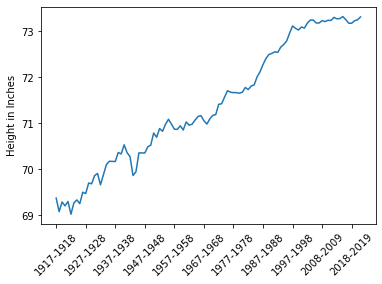

In [11]:
fig, ax = plt.subplots()
# ax = plt.gca()
ax.plot(rosters_df.groupby('season')['player_heights_inches'].mean())
# ax.axes.xaxis.set_visible(False)
ticks = rosters_df.groupby('season')['player_heights_inches'].mean().index[::10]
plt.xticks(ticks, rotation=45)
# ax.set_xticks(rosters_df.groupby('season')['player_heights_inches'].mean().index[::10])
plt.ylabel("Height in Inches");

#### Avg. Player Weight by Season

Similar to the 'Average Height' report, weight has also been steadily increasing over the last century. Interstingly though there's been a decrease over the last 20 (which is on par with the leveling-off we saw in the height graph).

While physicality has and always will be an important factor in the game, skating ability and overall game speed has increased tremendously as training techniques,  facilities and player equipment has improved over the years. This means a player's speed and quickness is more imorant than ever, which could be contributing the declining average weight.

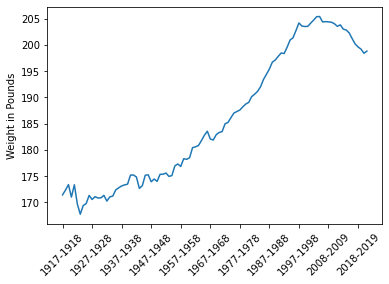

In [12]:
# fig, ax = plt.subplots(1,2, figsize=(16,4))
fig, ax = plt.subplots()
# ax = plt.gca()
ax.plot(rosters_df.groupby('season')['player_weights'].mean())
# ax.axes.xaxis.set_visible(False)
ticks = rosters_df.groupby('season')['player_weights'].mean().index[::10]
plt.xticks(ticks, rotation=45)
# ax.set_xticks(rosters_df.groupby('season')['player_weights'].mean().index[::10])
plt.ylabel("Weight in Pounds");

#### Avg. Player Age by Season

Average player age has flucuated over the last century, but the total trend line shows that the total average decrease in age isn't that significant.

Important to note that the technique for calculating each players' age by season was NOT an exact process. These numbers should be taken with a grain of salt.

In [53]:
# Add new column to rosters_df for each players age by season
# For the sake of this initial trend report I'm digging that hard into exact ages. Simply an approximation.
# int(rosters_df['season'][0][0:4])
rosters_df['season_start_year'] = [int(i[0:4]) for i in rosters_df['season']]
rosters_df['approx_player_age'] = rosters_df['season_start_year'] - rosters_df['player_birth_years']

y=-0.002807x+(26.351333)


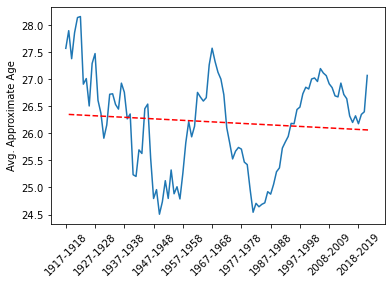

In [54]:
# fig, ax = plt.subplots(1,2, figsize=(16,4))
fig, ax = plt.subplots()
# ax = plt.gca()
ax.plot(rosters_df.groupby('season')['approx_player_age'].mean())
# ax.axes.xaxis.set_visible(False)
ticks = rosters_df.groupby('season')['approx_player_age'].mean().index[::10]
plt.xticks(ticks, rotation=45)
# ax.set_xticks(rosters_df.groupby('season')['player_weights'].mean().index[::10])
plt.ylabel("Avg. Approximate Age")

x = [i for i in range(1, len(rosters_df.groupby('season')['approx_player_age'].mean().index) + 1)]
y = rosters_df.groupby('season')['approx_player_age'].mean().values

# calc the trendline
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
pylab.plot(x,p(x),"r--");

print(f"y=%.6fx+(%.6f)"%(z[0],z[1]))


#### Side-by-side Comparison

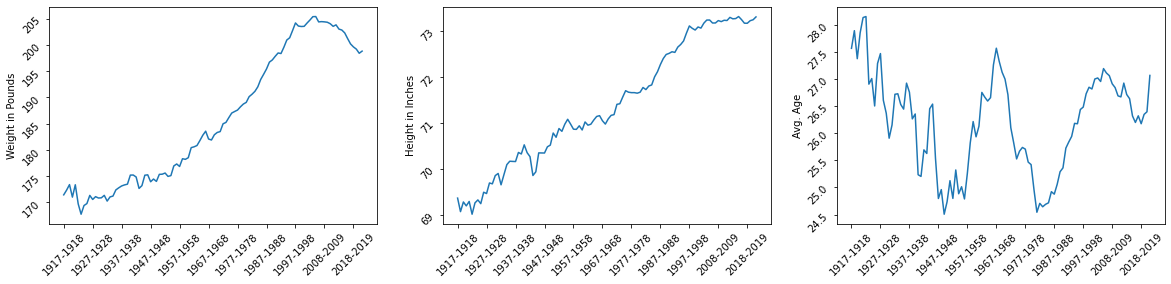

In [62]:
fig, ax = plt.subplots(1,3, figsize=(20,4))

ax[0].plot(rosters_df.groupby('season')['player_weights'].mean())
ax[0].set_ylabel('Weight in Pounds')
weight_ticks = rosters_df.groupby('season')['player_weights'].mean().index[::10]
ax[0].set_xticks(rosters_df.groupby('season')['player_weights'].mean().index[::10])
ax[0].tick_params(labelrotation=45)
plt.ylabel("Weight in Pounds")

ax[1].plot(rosters_df.groupby('season')['player_heights_inches'].mean())
ax[1].set_ylabel('Height in Inches')
height_ticks = rosters_df.groupby('season')['player_heights_inches'].mean().index[::10]
ax[1].set_xticks(rosters_df.groupby('season')['player_heights_inches'].mean().index[::10])
ax[1].tick_params(labelrotation=45)

ax[2].plot(rosters_df.groupby('season')['approx_player_age'].mean())
ax[2].set_ylabel('Avg. Age')
age_ticks = rosters_df.groupby('season')['approx_player_age'].mean().index[::10]
ax[2].set_xticks(rosters_df.groupby('season')['approx_player_age'].mean().index[::10])
ax[2].tick_params(labelrotation=45)

#### Geography

How many players from players_df have differing birth countries and nationalities?

In [104]:
total_players = len(players_df)
diff_count = len(players_df[players_df['player_birthcountries'] != players_df['player_nationalities']])
percent_of_total = round(diff_count/total_players, 2)

print(f'Total players: {total_players}')
print(f'Players with nationalities different than their birth country: {diff_count}')
print(f'Percentage: {percent_of_total}')

Total players: 8206
Players with nationalities different than their birth country: 128
Percentage: 0.02


In [226]:
# players_df.groupby(players_df['player_nationalities']).count().sort_values(by='player_ids', ascending=False).head(10)

In [259]:
# nation_percents_2['formatted_values'] = ["%" + str(round(i * 100, 2)) for i in nation_percents_2.values]
# nation_percents_2

<ipython-input-297-fc07314c6d5b>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x, rotation=45)


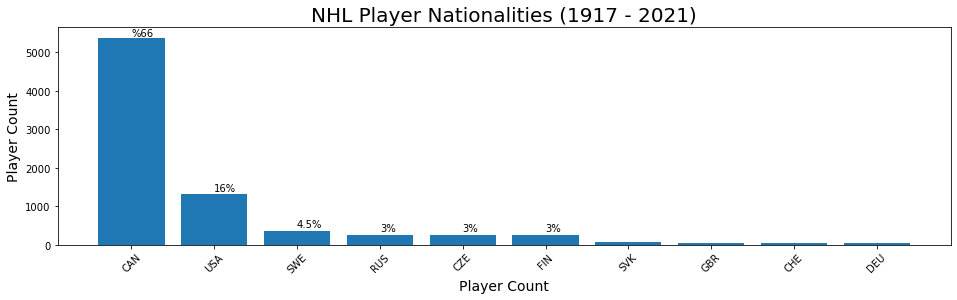

In [297]:
# players_df['player_birthcountries'].value_counts()
    
birthcountries_df = players_df.groupby(players_df['player_birthcountries'])['player_ids'].count().sort_values(ascending=False)

x = birthcountries_df.index[0:10]
y = birthcountries_df.values[0:10]

fig, ax = plt.subplots(figsize=(16,4))
ax.bar(x, y)
ax.set_xticklabels(x, rotation=45)
ax.text('CAN', 5425, '%66')
ax.text('USA', 1400, '16%')
ax.text('SWE', 450, '4.5%')
ax.text('RUS', 350, '3%')
ax.text('CZE', 350, '3%')
ax.text('FIN', 350, '3%')
ax.set_ylabel('Player Count', fontsize=14)
ax.set_xlabel('Player Count', fontsize=14)
ax.set_title('NHL Player Nationalities (1917 - 2021)', fontsize=20);

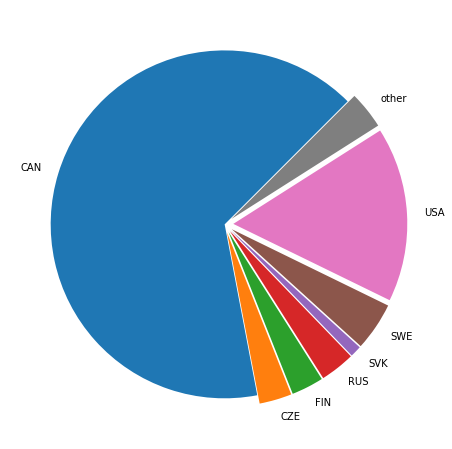

In [221]:
nation_percents = players_df['player_birthcountries'].value_counts(normalize=True)
nation_percents.index = [nation_percents.index[i] if nation_percents[i] >= 0.01 else 'other'for i in range(0, len(nation_percents))]
fig, ax = plt.subplots(figsize=(16,8))
ax = plt.pie(nation_percents.groupby(nation_percents.index).sum(), 
             startangle=45, labels=nation_percents.groupby(nation_percents.index).sum().index, 
             explode=[0, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]);

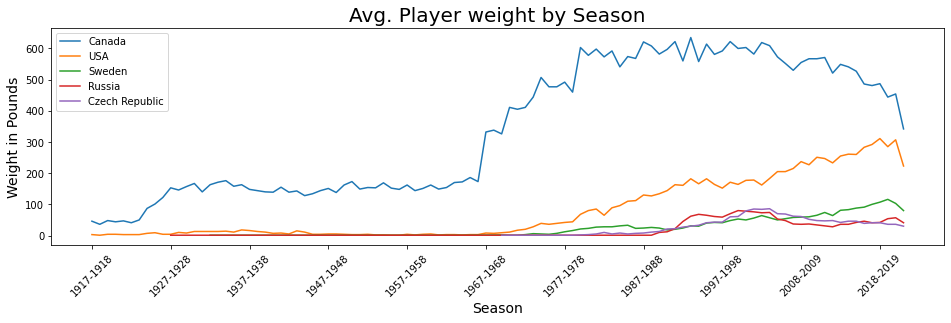

In [300]:
# rosters_df.groupby('player_nationalities').count().sort_values('season', ascending=False).head(10)
can = rosters_df[rosters_df['player_nationalities'] == 'CAN'].groupby('season')['player_ids'].count()
usa = rosters_df[rosters_df['player_nationalities'] == 'USA'].groupby('season')['player_ids'].count()
swe = rosters_df[rosters_df['player_nationalities'] == 'SWE'].groupby('season')['player_ids'].count()
rus = rosters_df[rosters_df['player_nationalities'] == 'RUS'].groupby('season')['player_ids'].count()
cze = rosters_df[rosters_df['player_nationalities'] == 'CZE'].groupby('season')['player_ids'].count()

fig, ax = plt.subplots(figsize=(16,4))

ax.plot(can, label='Canada')
ax.plot(usa, label='USA')
ax.plot(swe, label='Sweden')
ax.plot(rus, label='Russia')
ax.plot(cze, label='Czech Republic')
ax.legend()

ticks = can.index[::10]
plt.xticks(ticks, rotation=45)

plt.ylabel("Weight in Pounds", fontsize=14)
plt.xlabel("Season", fontsize=14)
plt.title("Avg. Player weight by Season", fontsize=20);

#### Size by position

In [134]:
players_df.groupby('player_positions')

SyntaxError: invalid syntax (<ipython-input-134-ec397e60d5a4>, line 1)

In [135]:
#Converting player heights to floats (inches)

players_df['player_heights_inches'] = players_df['player_heights']
players_df[['player_heights_inches_from_feet','player_heights_remaining_inches']] = players_df['player_heights_inches'].str.split("'",expand=True)

players_df['player_heights_remaining_inches'] = players_df['player_heights_remaining_inches'].map(lambda x: float(str(x).strip('"')))
players_df['player_heights_inches_from_feet'] = players_df['player_heights_inches_from_feet'].map(lambda x: float(x) * 12)

players_df['player_heights_inches'] = players_df['player_heights_inches_from_feet'] + players_df['player_heights_remaining_inches']


In [136]:
#Drop the extra height columns created along the way
players_df.drop(columns=['player_heights_inches_from_feet', 'player_heights_remaining_inches'], inplace=True)

In [137]:
position_size_df = players_df.groupby('player_positions')['player_heights_inches', 'player_weights'].mean().sort_values(by='player_weights', ascending=False)
position_size_df

<ipython-input-137-66957328c00b>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  position_size_df = players_df.groupby('player_positions')['player_heights_inches', 'player_weights'].mean().sort_values(by='player_weights', ascending=False)


player_heights_inches  player_weights
player_positions                                       
Defenseman                    72.939243      198.727840
Left Wing                     72.056663      192.144368
Right Wing                    71.845642      190.842981
Center                        71.676708      187.201721
Goalie                        71.898058      185.080194

''

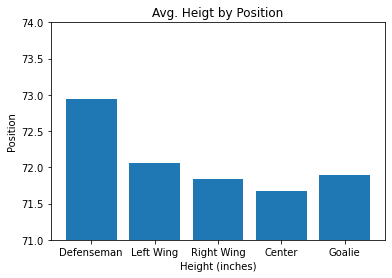

In [147]:
plt.bar(position_size_df.index, position_size_df['player_heights_inches'])
plt.ylim(71, 74)
plt.title("Avg. Heigt by Position")
plt.xlabel("Height (inches)")
plt.ylabel("Position")
;

#### Handedness

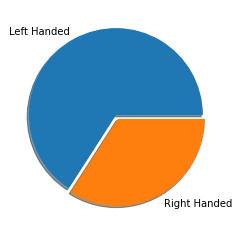

In [156]:
labels='Left Handed', 'Right Handed'

plt.pie(players_df.groupby('player_handedness')['player_handedness'].count(), explode=(0, 0.05), shadow=True,
       labels=labels);

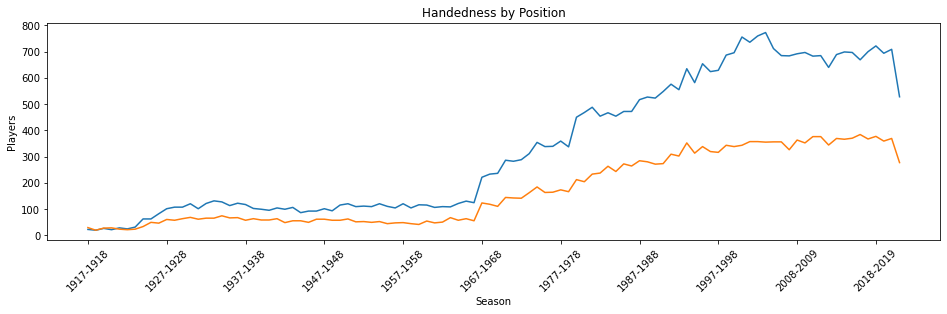

In [164]:
righthand_df = rosters_df[rosters_df['player_handedness'] == 'R'].groupby('season')['player_ids'].count()
lefthand_df = rosters_df[rosters_df['player_handedness'] == 'L'].groupby('season')['player_ids'].count()

fig, ax = plt.subplots(figsize=(16,4))

ax.plot(lefthand_df, label='Left-Handed Players')
ax.plot(righthand_df, label='Right-Handed Players')

ticks = lefthand_df.index[::10]
plt.xticks(ticks, rotation=45)

plt.ylabel("Players")
plt.xlabel('Season')
plt.title("Handedness by Position");